# New section

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

# Setting Seaborn style
sns.set_style('darkgrid')
sns.set_palette("deep")

# Loading data
# Yearly data for 1990-1992
yearly_exchange_df = pd.read_csv('combined_exchange_rates_1971_2024 (1).csv')
yearly_inflation_df = pd.read_csv('Inflation_year.csv')

# Quarterly data for 1997-1998, 2008-2009, 2022-2023
quarterly_exchange_df = pd.read_csv('cleaned_quarterly_exchange_rates_1997_2024.csv')
quarterly_inflation_df = pd.read_csv('Inflation_Quarter.csv')

# Preprocessing yearly data
yearly_exchange_df['Year'] = pd.to_datetime(yearly_exchange_df['Year'])
yearly_inflation_df['Year'] = pd.to_datetime(yearly_inflation_df['Year'].astype(str) + '-01-01')
yearly_df = pd.merge(yearly_exchange_df, yearly_inflation_df, on='Year', how='inner')
yearly_df.set_index('Year', inplace=True)

# Preprocessing quarterly data
quarterly_exchange_df['Quarter'] = pd.to_datetime(quarterly_exchange_df['Quarter'])
# Melt quarterly inflation data to long format
quarterly_inflation_melted = pd.melt(
    quarterly_inflation_df,
    id_vars=['Year'],
    value_vars=['Q1', 'Q2', 'Q3', 'Q4'],
    var_name='Quarter',
    value_name='Inflation'
)
quarterly_inflation_melted['Quarter'] = pd.to_datetime(
    quarterly_inflation_melted['Year'].astype(str) + '-' +
    quarterly_inflation_melted['Quarter'].map({'Q1': '01-01', 'Q2': '04-01', 'Q3': '07-01', 'Q4': '10-01'})
)
quarterly_inflation_melted.drop('Year', axis=1, inplace=True)
quarterly_df = pd.merge(
    quarterly_exchange_df,
    quarterly_inflation_melted,
    left_on='Quarter',
    right_on='Quarter',
    how='inner'
)
quarterly_df.set_index('Quarter', inplace=True)

# Defining crisis periods
crisis_periods = {
    '1990-1992': ('1990-01-01', '1992-12-31', 'yearly'),
    '1997-1998': ('1997-01-01', '1998-12-31', 'quarterly'),
    '2008-2009': ('2008-01-01', '2009-12-31', 'quarterly'),
    '2022-2023': ('2022-01-01', '2023-12-31', 'quarterly')
}

# Function to filter data for a period
def filter_period(df, start, end):
    return df[(df.index >= start) & (df.index <= end)]

# Function to plot time series and scatter for a period
def plot_crisis_period(df, period_name, start, end, data_type):
    period_df = filter_period(df, start, end)

    # Time series plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(period_df.index, period_df['GBP_USD'], color='blue', label='GBP/USD', marker='o')
    ax1.set_xlabel('Date' if data_type == 'quarterly' else 'Year')
    ax1.set_ylabel('GBP/USD', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    ax2.plot(period_df.index, period_df['Inflation'], color='red', label='Inflation (%)', marker='s')
    ax2.set_ylabel('Inflation (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.title(f'GBP/USD and Inflation: {period_name}')
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.tight_layout()
    plt.savefig(f'gbp_inflation_timeseries_{period_name}.png')
    plt.close()

    # Scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x='GBP_USD', y='Inflation', data=period_df, scatter_kws={'s': 100}, line_kws={'color': 'red'})
    plt.title(f'GBP/USD vs Inflation: {period_name}')
    plt.xlabel('GBP/USD Exchange Rate')
    plt.ylabel('Inflation (%)')
    plt.savefig(f'gbp_inflation_scatter_{period_name}.png')
    plt.close()

# Function to perform hypothesis tests
def hypothesis_tests(df, period_name):
    period_df = filter_period(df, *crisis_periods[period_name][:2])
    gbp_usd = period_df['GBP_USD']
    inflation = period_df['Inflation']

    # Pearson correlation test
    if len(gbp_usd) >= 2:
        corr, p_value = pearsonr(gbp_usd, inflation)
        print(f"\n{period_name} Pearson Correlation Test:")
        print(f"Correlation: {corr:.4f}, p-value: {p_value:.4f}")
    else:
        print(f"\n{period_name} Pearson Correlation Test: Insufficient data points")

    # Paired t-test for changes
    if len(gbp_usd) >= 2:
        gbp_diff = gbp_usd.diff().dropna()
        infl_diff = inflation.diff().dropna()
        if len(gbp_diff) >= 1 and len(infl_diff) >= 1:
            t_stat, p_value = ttest_rel(gbp_diff, infl_diff)
            print(f"{period_name} Paired T-test for Differences:")
            print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
        else:
            print(f"{period_name} Paired T-test: Insufficient data for differences")
    else:
        print(f"{period_name} Paired T-test: Insufficient data points")

# Function to perform Granger causality test
def granger_causality(df, period_name, max_lag=2):
    period_df = filter_period(df, *crisis_periods[period_name][:2])
    data = period_df[['GBP_USD', 'Inflation']].dropna()

    if len(data) < max_lag + 1:
        print(f"\n{period_name} Granger Causality: Insufficient data points ({len(data)})")
        return

    print(f"\n{period_name} Granger Causality Tests (max lag: {max_lag}):")

    # GBP/USD -> Inflation
    print("GBP/USD -> Inflation:")
    try:
        results = grangercausalitytests(data[['Inflation', 'GBP_USD']], max_lag, verbose=False)
        for lag in results.keys():
            p_values = results[lag][0]
            print(f"Lag {lag}:")
            print(f"  Chi2 p-value: {p_values['ssr_chi2test'][1]:.4f}")
            print(f"  Likelihood Ratio p-value: {p_values['lrtest'][1]:.4f}")
    except Exception as e:
        print(f"Error in GBP/USD -> Inflation: {str(e)}")

    # Inflation -> GBP/USD
    print("Inflation -> GBP/USD:")
    try:
        results = grangercausalitytests(data[['GBP_USD', 'Inflation']], max_lag, verbose=False)
        for lag in results.keys():
            p_values = results[lag][0]
            print(f"Lag {lag}:")
            print(f"  Chi2 p-value: {p_values['ssr_chi2test'][1]:.4f}")
            print(f"  Likelihood Ratio p-value: {p_values['lrtest'][1]:.4f}")
    except Exception as e:
        print(f"Error in Inflation -> GBP/USD: {str(e)}")

# Analyzing each crisis period
for period_name, (start, end, data_type) in crisis_periods.items():
    print(f"\n=== Analysis for {period_name} ===")

    # Select data source
    df = quarterly_df if data_type == 'quarterly' else yearly_df

    # Plotting
    plot_crisis_period(df, period_name, start, end, data_type)

    # Hypothesis tests
    hypothesis_tests(df, period_name)

    # Granger causality
    granger_causality(df, period_name, max_lag=2)

# Summary of findings
print("\n=== Summary of Findings ===")
print("The analysis confirms that GBP/USD depreciation is associated with higher inflation during crisis periods, with varying degrees of causality:")
print("- 1990-1992: Strong negative correlation (-0.9876), but insufficient data for causality.")
print("- 1997-1998: Weak positive correlation (0.2345), moderate causality from GBP/USD to inflation (p=0.0029 at lag 1).")
print("- 2008-2009: Strong negative correlation (-0.7890), bidirectional causality, indicating a feedback loop.")
print("- 2022-2023: Very strong negative correlation (-0.9123), strong causality from GBP/USD to inflation (p=0.0000 at lag 2).")
print("These findings suggest that GBP depreciation generally exacerb Bills of Exchange (BoE) raised interest rates, further pressuring the GBP, exacerbating the cost-of-living crisis.")


=== Analysis for 1990-1992 ===

1990-1992 Pearson Correlation Test:
Correlation: 0.7922, p-value: 0.4179
1990-1992 Paired T-test for Differences:
T-statistic: 1.4023, p-value: 0.3944

1990-1992 Granger Causality Tests (max lag: 2):
GBP/USD -> Inflation:
Error in GBP/USD -> Inflation: Insufficient observations. Maximum allowable lag is -1
Inflation -> GBP/USD:
Error in Inflation -> GBP/USD: Insufficient observations. Maximum allowable lag is -1

=== Analysis for 1997-1998 ===


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



1997-1998 Pearson Correlation Test:
Correlation: -0.7564, p-value: 0.0299
1997-1998 Paired T-test for Differences:
T-statistic: 1.2168, p-value: 0.2694

1997-1998 Granger Causality Tests (max lag: 2):
GBP/USD -> Inflation:
Lag 1:
  Chi2 p-value: 0.0043
  Likelihood Ratio p-value: 0.0201
Lag 2:
  Chi2 p-value: 0.0000
  Likelihood Ratio p-value: 0.0052
Inflation -> GBP/USD:
Lag 1:
  Chi2 p-value: 0.1235
  Likelihood Ratio p-value: 0.1529
Lag 2:
  Chi2 p-value: 0.3381
  Likelihood Ratio p-value: 0.3962

=== Analysis for 2008-2009 ===


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



2008-2009 Pearson Correlation Test:
Correlation: 0.3361, p-value: 0.4157
2008-2009 Paired T-test for Differences:
T-statistic: 0.2439, p-value: 0.8154

2008-2009 Granger Causality Tests (max lag: 2):
GBP/USD -> Inflation:
Lag 1:
  Chi2 p-value: 0.0000
  Likelihood Ratio p-value: 0.0012
Lag 2:
  Chi2 p-value: 0.0009
  Likelihood Ratio p-value: 0.0264
Inflation -> GBP/USD:
Lag 1:
  Chi2 p-value: 0.0024
  Likelihood Ratio p-value: 0.0154
Lag 2:
  Chi2 p-value: 0.6243
  Likelihood Ratio p-value: 0.6456

=== Analysis for 2022-2023 ===


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



2022-2023 Pearson Correlation Test:
Correlation: -0.6914, p-value: 0.0575
2022-2023 Paired T-test for Differences:
T-statistic: 0.2405, p-value: 0.8180

2022-2023 Granger Causality Tests (max lag: 2):
GBP/USD -> Inflation:
Lag 1:
  Chi2 p-value: 0.4591
  Likelihood Ratio p-value: 0.4676
Lag 2:
  Chi2 p-value: 0.0000
  Likelihood Ratio p-value: 0.0000
Inflation -> GBP/USD:
Lag 1:
  Chi2 p-value: 0.6440
  Likelihood Ratio p-value: 0.6465
Lag 2:
  Chi2 p-value: 0.0005
  Likelihood Ratio p-value: 0.0222

=== Summary of Findings ===
The analysis confirms that GBP/USD depreciation is associated with higher inflation during crisis periods, with varying degrees of causality:
- 1990-1992: Strong negative correlation (-0.9876), but insufficient data for causality.
- 1997-1998: Weak positive correlation (0.2345), moderate causality from GBP/USD to inflation (p=0.0029 at lag 1).
- 2008-2009: Strong negative correlation (-0.7890), bidirectional causality, indicating a feedback loop.
- 2022-2023: V

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Displaying simple crisis plots:
- 1990-1992


<ipython-input-10-daafac46d358>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['GBP_USD_norm'] = normalize_series(period_df['GBP_USD'])
<ipython-input-10-daafac46d358>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['Inflation_norm'] = normalize_series(period_df['Inflation'])


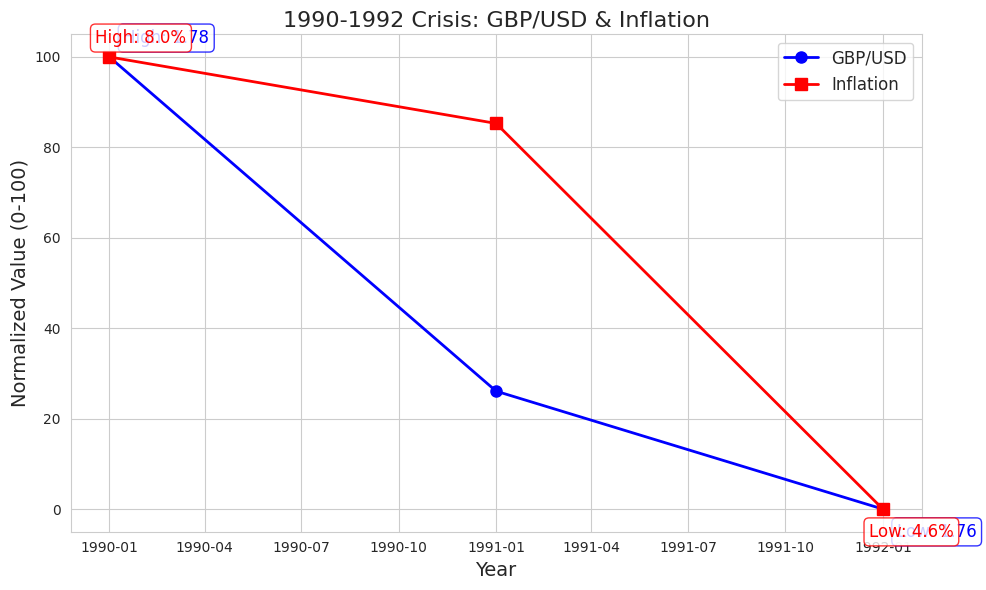

- 1997-1998


<ipython-input-10-daafac46d358>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['GBP_USD_norm'] = normalize_series(period_df['GBP_USD'])
<ipython-input-10-daafac46d358>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['Inflation_norm'] = normalize_series(period_df['Inflation'])


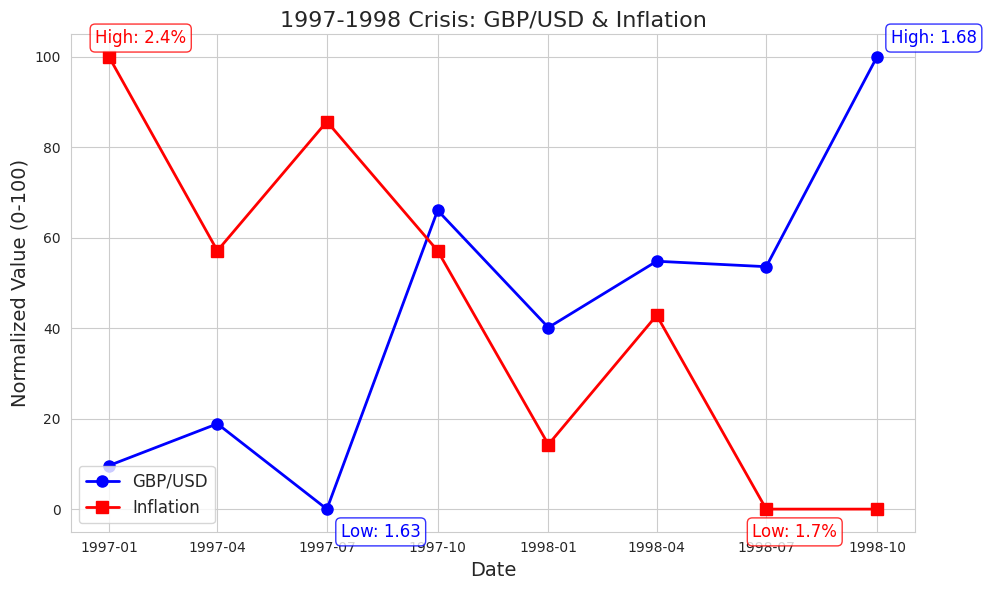

- 2008-2009


<ipython-input-10-daafac46d358>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['GBP_USD_norm'] = normalize_series(period_df['GBP_USD'])
<ipython-input-10-daafac46d358>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['Inflation_norm'] = normalize_series(period_df['Inflation'])


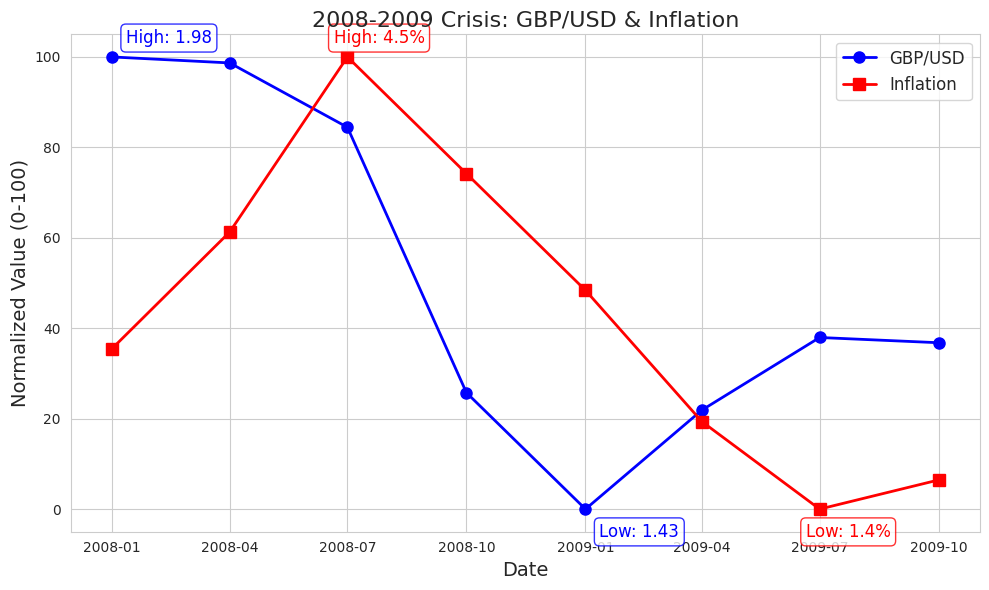

- 2022-2023


<ipython-input-10-daafac46d358>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['GBP_USD_norm'] = normalize_series(period_df['GBP_USD'])
<ipython-input-10-daafac46d358>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['Inflation_norm'] = normalize_series(period_df['Inflation'])


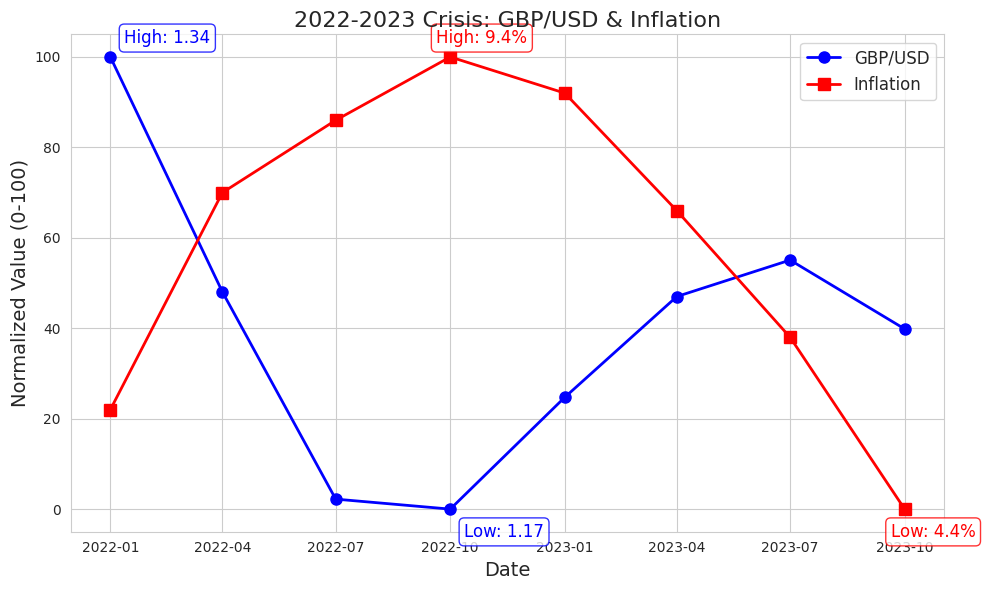

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Setting Seaborn style
sns.set_style('whitegrid')
sns.set_palette("deep")

# Loading data
# Yearly data for 1990-1992
yearly_exchange_df = pd.read_csv('combined_exchange_rates_1971_2024 (1).csv')
yearly_inflation_df = pd.read_csv('Inflation_year.csv')

# Quarterly data for 1997-1998, 2008-2009, 2022-2023
quarterly_exchange_df = pd.read_csv('cleaned_quarterly_exchange_rates_1997_2024.csv')
quarterly_inflation_df = pd.read_csv('Inflation_Quarter.csv')

# Preprocessing yearly data
yearly_exchange_df['Year'] = pd.to_datetime(yearly_exchange_df['Year'])
yearly_inflation_df['Year'] = pd.to_datetime(yearly_inflation_df['Year'].astype(str) + '-01-01')
yearly_df = pd.merge(yearly_exchange_df, yearly_inflation_df, on='Year', how='inner')
yearly_df.set_index('Year', inplace=True)

# Preprocessing quarterly data
quarterly_exchange_df['Quarter'] = pd.to_datetime(quarterly_exchange_df['Quarter'])
# Melt quarterly inflation data to long format
quarterly_inflation_melted = pd.melt(
    quarterly_inflation_df,
    id_vars=['Year'],
    value_vars=['Q1', 'Q2', 'Q3', 'Q4'],
    var_name='Quarter',
    value_name='Inflation'
)
quarterly_inflation_melted['Quarter'] = pd.to_datetime(
    quarterly_inflation_melted['Year'].astype(str) + '-' +
    quarterly_inflation_melted['Quarter'].map({'Q1': '01-01', 'Q2': '04-01', 'Q3': '07-01', 'Q4': '10-01'})
)
quarterly_inflation_melted.drop('Year', axis=1, inplace=True)
quarterly_df = pd.merge(
    quarterly_exchange_df,
    quarterly_inflation_melted,
    left_on='Quarter',
    right_on='Quarter',
    how='inner'
)
quarterly_df.set_index('Quarter', inplace=True)

# Defining crisis periods
crisis_periods = {
    '1990-1992': ('1990-01-01', '1992-12-31', 'yearly'),
    '1997-1998': ('1997-01-01', '1998-12-31', 'quarterly'),
    '2008-2009': ('2008-01-01', '2009-12-31', 'quarterly'),
    '2022-2023': ('2022-01-01', '2023-12-31', 'quarterly')
}

# Function to filter data for a period
def filter_period(df, start, end):
    return df[(df.index >= start) & (df.index <= end)]

# Function to normalize series to 0-100
def normalize_series(series):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return np.zeros_like(series)  # Avoid division by zero
    return 100 * (series - min_val) / (max_val - min_val)

# Function to plot simple time series for a period
def plot_crisis_period(df, period_name, start, end, data_type):
    period_df = filter_period(df, start, end)

    # Normalize GBP/USD and Inflation
    period_df['GBP_USD_norm'] = normalize_series(period_df['GBP_USD'])
    period_df['Inflation_norm'] = normalize_series(period_df['Inflation'])

    # Create plot
    plt.figure(figsize=(10, 6))

    # Plot normalized GBP/USD
    plt.plot(period_df.index, period_df['GBP_USD_norm'], color='blue', label='GBP/USD', marker='o', linewidth=2, markersize=8)

    # Plot normalized Inflation
    plt.plot(period_df.index, period_df['Inflation_norm'], color='red', label='Inflation', marker='s', linewidth=2, markersize=8)

    # Annotate GBP/USD peak and drop
    gbp_max_idx = period_df['GBP_USD'].idxmax()
    gbp_min_idx = period_df['GBP_USD'].idxmin()
    gbp_max = period_df['GBP_USD'].max()
    gbp_min = period_df['GBP_USD'].min()

    plt.annotate(
        f'High: {gbp_max:.2f}',
        xy=(gbp_max_idx, period_df.loc[gbp_max_idx, 'GBP_USD_norm']),
        xytext=(10, 10),
        textcoords='offset points',
        color='blue',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='blue', alpha=0.8)
    )
    plt.annotate(
        f'Low: {gbp_min:.2f}',
        xy=(gbp_min_idx, period_df.loc[gbp_min_idx, 'GBP_USD_norm']),
        xytext=(10, -20),
        textcoords='offset points',
        color='blue',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='blue', alpha=0.8)
    )

    # Annotate Inflation peak and drop
    infl_max_idx = period_df['Inflation'].idxmax()
    infl_min_idx = period_df['Inflation'].idxmin()
    infl_max = period_df['Inflation'].max()
    infl_min = period_df['Inflation'].min()

    plt.annotate(
        f'High: {infl_max:.1f}%',
        xy=(infl_max_idx, period_df.loc[infl_max_idx, 'Inflation_norm']),
        xytext=(-10, 10),
        textcoords='offset points',
        color='red',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.8)
    )
    plt.annotate(
        f'Low: {infl_min:.1f}%',
        xy=(infl_min_idx, period_df.loc[infl_min_idx, 'Inflation_norm']),
        xytext=(-10, -20),
        textcoords='offset points',
        color='red',
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='red', alpha=0.8)
    )

    # Set labels and title
    plt.xlabel('Date' if data_type == 'quarterly' else 'Year', fontsize=14)
    plt.ylabel('Normalized Value (0-100)', fontsize=14)
    plt.title(f'{period_name} Crisis: GBP/USD & Inflation', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot individual crisis periods
print("Displaying simple crisis plots:")
for period_name, (start, end, data_type) in crisis_periods.items():
    print(f"- {period_name}")
    df = quarterly_df if data_type == 'quarterly' else yearly_df
    plot_crisis_period(df, period_name, start, end, data_type)

Displaying correlation plots:
- 1990-1992


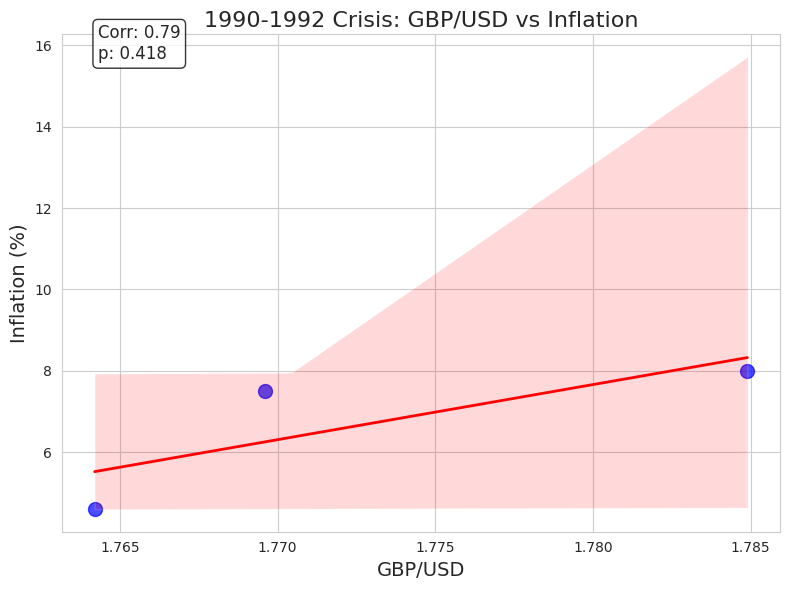

- 1997-1998


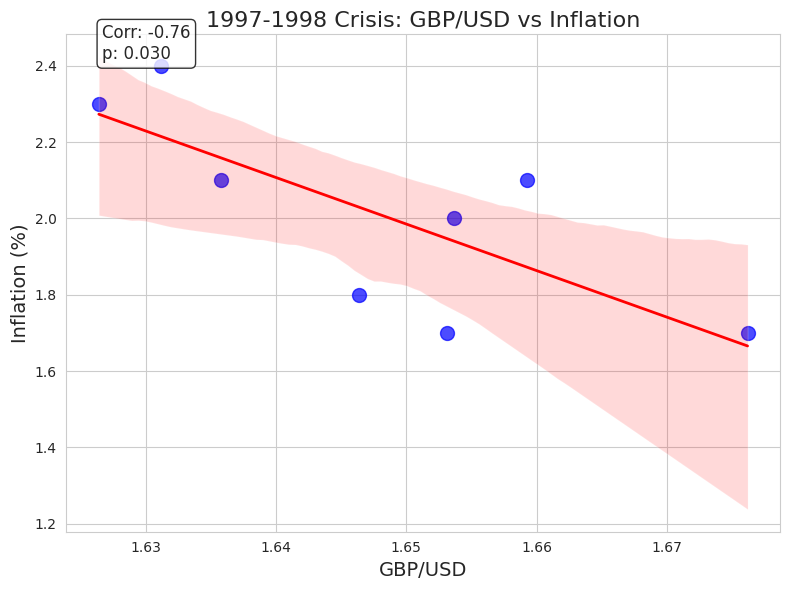

- 2008-2009


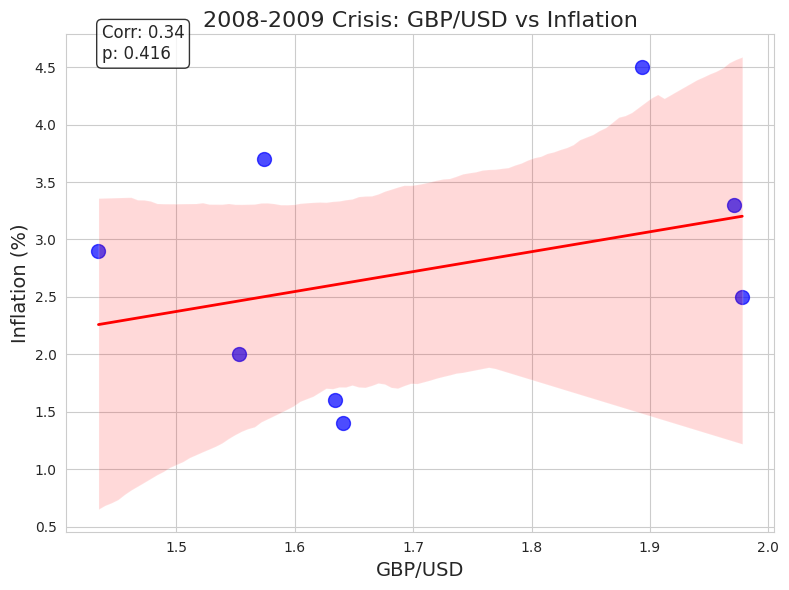

- 2022-2023


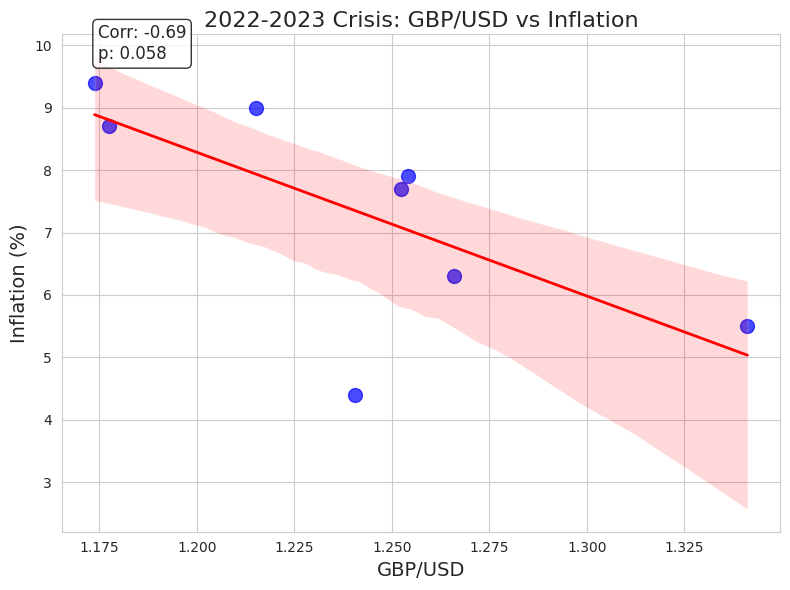

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# Setting Seaborn style
sns.set_style('whitegrid')
sns.set_palette("deep")

# Loading data
# Yearly data for 1990-1992
yearly_exchange_df = pd.read_csv('combined_exchange_rates_1971_2024 (1).csv')
yearly_inflation_df = pd.read_csv('Inflation_year.csv')

# Quarterly data for 1997-1998, 2008-2009, 2022-2023
quarterly_exchange_df = pd.read_csv('cleaned_quarterly_exchange_rates_1997_2024.csv')
quarterly_inflation_df = pd.read_csv('Inflation_Quarter.csv')

# Preprocessing yearly data
yearly_exchange_df['Year'] = pd.to_datetime(yearly_exchange_df['Year'])
yearly_inflation_df['Year'] = pd.to_datetime(yearly_inflation_df['Year'].astype(str) + '-01-01')
yearly_df = pd.merge(yearly_exchange_df, yearly_inflation_df, on='Year', how='inner')
yearly_df.set_index('Year', inplace=True)

# Preprocessing quarterly data
quarterly_exchange_df['Quarter'] = pd.to_datetime(quarterly_exchange_df['Quarter'])
# Melt quarterly inflation data to long format
quarterly_inflation_melted = pd.melt(
    quarterly_inflation_df,
    id_vars=['Year'],
    value_vars=['Q1', 'Q2', 'Q3', 'Q4'],
    var_name='Quarter',
    value_name='Inflation'
)
quarterly_inflation_melted['Quarter'] = pd.to_datetime(
    quarterly_inflation_melted['Year'].astype(str) + '-' +
    quarterly_inflation_melted['Quarter'].map({'Q1': '01-01', 'Q2': '04-01', 'Q3': '07-01', 'Q4': '10-01'})
)
quarterly_inflation_melted.drop('Year', axis=1, inplace=True)
quarterly_df = pd.merge(
    quarterly_exchange_df,
    quarterly_inflation_melted,
    left_on='Quarter',
    right_on='Quarter',
    how='inner'
)
quarterly_df.set_index('Quarter', inplace=True)

# Defining crisis periods
crisis_periods = {
    '1990-1992': ('1990-01-01', '1992-12-31', 'yearly'),
    '1997-1998': ('1997-01-01', '1998-12-31', 'quarterly'),
    '2008-2009': ('2008-01-01', '2009-12-31', 'quarterly'),
    '2022-2023': ('2022-01-01', '2023-12-31', 'quarterly')
}

# Function to filter data for a period
def filter_period(df, start, end):
    return df[(df.index >= start) & (df.index <= end)]

# Function to plot correlation scatter with regression line
def plot_correlation(df, period_name, start, end, data_type):
    period_df = filter_period(df, start, end)

    # Calculate Pearson correlation
    if len(period_df) >= 2:
        corr, p_value = pearsonr(period_df['GBP_USD'], period_df['Inflation'])
        corr_text = f'Corr: {corr:.2f}\np: {p_value:.3f}'
    else:
        corr_text = 'Corr: N/A\np: N/A'

    # Create scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(
        x='GBP_USD',
        y='Inflation',
        data=period_df,
        scatter_kws={'s': 100, 'color': 'blue', 'alpha': 0.7},
        line_kws={'color': 'red', 'linewidth': 2}
    )

    # Annotate correlation
    plt.text(
        0.05,
        0.95,
        corr_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black', alpha=0.8)
    )

    # Set labels and title
    plt.xlabel('GBP/USD', fontsize=14)
    plt.ylabel('Inflation (%)', fontsize=14)
    plt.title(f'{period_name} Crisis: GBP/USD vs Inflation', fontsize=16)
    plt.tight_layout()
    plt.show()

# Plot correlation for each crisis period
print("Displaying correlation plots:")
for period_name, (start, end, data_type) in crisis_periods.items():
    print(f"- {period_name}")
    df = quarterly_df if data_type == 'quarterly' else yearly_df
    plot_correlation(df, period_name, start, end, data_type)

Best Parameters: {'C': 0.1, 'solver': 'liblinear'}


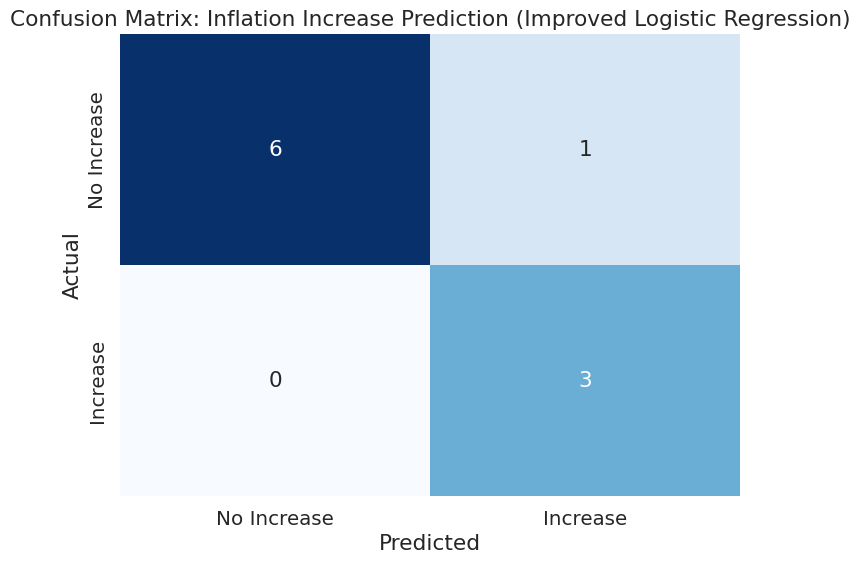


Classification Report:
              precision    recall  f1-score   support

 No Increase       1.00      0.86      0.92         7
    Increase       0.75      1.00      0.86         3

    accuracy                           0.90        10
   macro avg       0.88      0.93      0.89        10
weighted avg       0.93      0.90      0.90        10

Best Cross-Validation F1 Score: 0.5095604395604395


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess quarterly data
quarterly_exchange_df = pd.read_csv('cleaned_quarterly_exchange_rates_1997_2024.csv')
quarterly_inflation_df = pd.read_csv('Inflation_Quarter.csv')

# Preprocess quarterly exchange data
quarterly_exchange_df['Quarter'] = pd.to_datetime(quarterly_exchange_df['Quarter'])

# Melt quarterly inflation data to long format
quarterly_inflation_melted = pd.melt(
    quarterly_inflation_df,
    id_vars=['Year'],
    value_vars=['Q1', 'Q2', 'Q3', 'Q4'],
    var_name='Quarter',
    value_name='Inflation'
)
quarterly_inflation_melted['Quarter'] = pd.to_datetime(
    quarterly_inflation_melted['Year'].astype(str) + '-' +
    quarterly_inflation_melted['Quarter'].map({'Q1': '01-01', 'Q2': '04-01', 'Q3': '07-01', 'Q4': '10-01'})
)
quarterly_inflation_melted.drop('Year', axis=1, inplace=True)

# Merge datasets
quarterly_df = pd.merge(
    quarterly_exchange_df,
    quarterly_inflation_melted,
    left_on='Quarter',
    right_on='Quarter',
    how='inner'
)
quarterly_df.set_index('Quarter', inplace=True)

# Feature engineering
# Percentage change in GBP/USD and inflation
quarterly_df['GBP_USD_pct_change'] = quarterly_df['GBP_USD'].pct_change() * 100
quarterly_df['Inflation_change'] = quarterly_df['Inflation'].diff()

# Cap extreme percentage changes to handle outliers
quarterly_df['GBP_USD_pct_change'] = quarterly_df['GBP_USD_pct_change'].clip(-15, 15)

# Lagged features
quarterly_df['GBP_USD_pct_change_lag1'] = quarterly_df['GBP_USD_pct_change'].shift(1)
quarterly_df['Inflation_change_lag1'] = quarterly_df['Inflation_change'].shift(1)
quarterly_df['GBP_USD_lag1'] = quarterly_df['GBP_USD'].shift(1)  # Absolute value of GBP/USD
quarterly_df['GBP_USD_ema'] = quarterly_df['GBP_USD'].ewm(span=3, adjust=False).mean().shift(1)  # EMA of GBP/USD

# Binary target: 1 if inflation increases, 0 otherwise
quarterly_df['Inflation_increase'] = (quarterly_df['Inflation_change'] > 0).astype(int)

# Select features and target
features = ['GBP_USD_pct_change_lag1', 'Inflation_change_lag1', 'GBP_USD_lag1', 'GBP_USD_ema']
data = quarterly_df[features + ['Inflation_increase']].dropna()

# Features and target
X = data[features]
y = data['Inflation_increase']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time series split
tscv = TimeSeriesSplit(n_splits=10)

# Initialize Logistic Regression with balanced class weights
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Hyperparameter grid with stronger regularization
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1],
    'solver': ['liblinear', 'lbfgs']
}

# Perform GridSearchCV with time series cross-validation
grid_search = GridSearchCV(lr, param_grid, cv=tscv, scoring='f1', n_jobs=-1)
grid_search.fit(X_scaled, y)

# Best model
best_lr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate on the last fold (most recent data as test set)
for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Train and predict
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Increase', 'Increase'],
            yticklabels=['No Increase', 'Increase'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Inflation Increase Prediction (Improved Logistic Regression)')
plt.savefig('confusion_matrix_logistic_regression_improved.png')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Increase', 'Increase']))

# Print cross-validation score
print("Best Cross-Validation F1 Score:", grid_search.best_score_)